# **Bias Detection & Model Explainability on a Synthetic Hiring Dataset**

**Author** Srujan Sai Voodarla

**Goal:** Build a hiring classifier, inspect SHAP explanations, measure fairness metrics, and apply mitigation strategies to reduce unwanted bias.

This notebook provides an end-to-end workflow for detecting, understanding, and mitigating bias in machine learning models. We use a *synthetic* hiring dataset so we can precisely control how much bias is present and clearly demonstrate how fairness tools and SHAP explanations respond.

By the end of this notebook, you will learn how to:

- Generate datasets with configurable bias toward or against protected groups  
- Analyze model behavior using SHAP (global + local explanations)  
- Compute key fairness metrics such as Demographic Parity and Equal Opportunity  
- Compare feature attributions between demographic groups  
- Apply bias mitigation techniques and evaluate their effectiveness  

This notebook is entirely **self-contained** and requires no external data.


In [29]:
!pip install -U shap xgboost



In [30]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import xgboost as xgb
import shap
import os
print('libraries imported')

libraries imported


## **Data generation: synthetic hiring dataset**

To explore bias safely and reproducibly, we generate a synthetic hiring dataset with complete control over how protected groups (e.g., gender, race) are penalized or advantaged.

The generator function creates:

- Continuous skill-related features (e.g., experience, interview score)  
- Categorical demographic features (gender, race)  
- A binary “hire” variable influenced by both skills and optional bias penalties  

By adjusting the penalty values, we can simulate a variety of real-world situations, from mild bias to severe discrimination. This allows us to observe:

- How biased data leads to biased model predictions  
- How fairness metrics respond as bias increases  
- How SHAP explanations highlight the influence of demographic attributes  

This setup makes it easy to teach *cause → effect* relationships in fairness analysis.


In [31]:
def generate_synthetic_hiring(n=20000, seed=42, penalty_race=None, penalty_gender=None):
    """Generate a synthetic hiring dataset.
    - n: number of rows
    - penalty_race: dict mapping race to numeric penalty (e.g., {'Black': -5})
    - penalty_gender: dict mapping gender to numeric penalty (e.g., {'Female': -2})
    Returns a pandas DataFrame.
    """
    np.random.seed(seed)
    # Protected attributes
    gender = np.random.choice(['Male', 'Female'], size=n, p=[0.5, 0.5])
    race = np.random.choice(['White', 'Black', 'Hispanic', 'Asian'], size=n, p=[0.55, 0.2, 0.15, 0.1])
    # Features
    years_experience = np.round(np.random.normal(loc=5, scale=3, size=n).clip(0), 1)
    education_level = np.random.choice(['HS', 'Bachelors', 'Masters', 'PhD'], size=n, p=[0.15, 0.55, 0.25, 0.05])
    skill_score = np.round(np.clip(np.random.normal(loc=70, scale=15, size=n), 0, 100), 1)
    interview_score = np.round(np.clip(np.random.normal(loc=70, scale=12, size=n), 0, 100), 1)
    # Base score
    base_score = 0.4*skill_score + 0.4*interview_score + 0.2*(years_experience*10)
    # Apply penalties
    penalty = np.zeros(n)
    if penalty_race is None:
        penalty_race = {'Black': -5}
    if penalty_gender is None:
        penalty_gender = {'Female': -2}
    for r, p in penalty_race.items():
        penalty += np.where(race == r, p, 0)
    for g, p in penalty_gender.items():
        penalty += np.where(gender == g, p, 0)
    # Probability of hire via logistic on shifted score
    logits = (base_score + penalty - 70) / 10
    prob = 1 / (1 + np.exp(-logits))
    hire = np.random.binomial(1, prob)
    edu_map = {'HS':0, 'Bachelors':1, 'Masters':2, 'PhD':3}
    df = pd.DataFrame({
        'gender': gender,
        'race': race,
        'years_experience': years_experience,
        'education': education_level,
        'education_num': [edu_map[e] for e in education_level],
        'skill_score': skill_score,
        'interview_score': interview_score,
        'base_score': base_score,
        'penalty': penalty,
        'hire': hire
    })
    return df

# Generate and save a small dataset for quick runs
df = generate_synthetic_hiring(n=5000, seed=42)
df.to_csv('synthetic_hiring_small.csv', index=False)
print('Generated synthetic_hiring_small.csv with', len(df), 'rows')

Generated synthetic_hiring_small.csv with 5000 rows


## **Quick EDA**

Before building models, we examine the dataset to understand group-level patterns:

- **Overall hire rate**  
- **Hire rate by gender**  
- **Hire rate by race**

These descriptive statistics help reveal whether the synthetic penalties we introduced are reflected in the distribution of outcomes.

This step helps answer:

- Are certain groups under-selected even before modeling?  
- How large are the disparities introduced by the bias parameters?  
- Should we anticipate biased model behavior?

A simple EDA provides the baseline context needed for later SHAP and fairness evaluations.


Overall hire rate: 0.375

By gender:
 gender
Female    0.3412
Male      0.4088
Name: hire, dtype: float64

By race:
 race
Asian       0.398340
Black       0.299172
Hispanic    0.391931
White       0.392582
Name: hire, dtype: float64


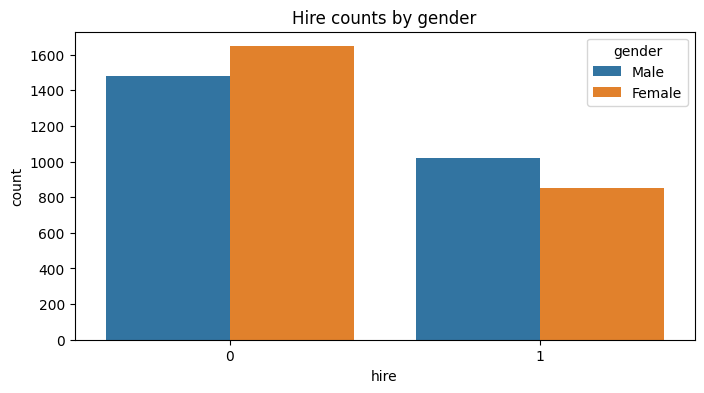

In [32]:
df = pd.read_csv('synthetic_hiring_small.csv')
print('Overall hire rate:', df['hire'].mean())
print('\nBy gender:\n', df.groupby('gender')['hire'].mean())
print('\nBy race:\n', df.groupby('race')['hire'].mean())

plt.figure(figsize=(8,4))
sns.countplot(x='hire', hue='gender', data=df)
plt.title('Hire counts by gender')
plt.show()

## **Feature preparation**

In this stage, we create the feature matrix used for modeling and preserve protected attributes for fairness evaluation.

Steps include:

- Selecting numeric predictor variables (experience, skill score, etc.)  
- One-hot encoding demographic categories so the model can use them  
- Keeping raw gender/race labels separately for fairness and SHAP grouping  
- Splitting the data into training and testing sets with stratification  

Proper feature preparation ensures:

- The model receives high-quality input features  
- Protected attributes are tracked for downstream fairness analysis  
- The pipeline is transparent and reproducible  

This mirrors real-world workflows used in fairness audits.


In [33]:
# Feature prep
X = df[['years_experience','education_num','skill_score','interview_score']].copy()
X = pd.concat([X, pd.get_dummies(df['gender'], prefix='gender'), pd.get_dummies(df['race'], prefix='race')], axis=1)
y = df['hire']
protected_gender = df['gender'].values
protected_race = df['race'].values

X_train, X_test, y_train, y_test, g_train, g_test, r_train, r_test = train_test_split(
    X, y, protected_gender, protected_race, test_size=0.3, random_state=42, stratify=df['hire']
)
print('Train size:', X_train.shape, 'Test size:', X_test.shape)

Train size: (3500, 10) Test size: (1500, 10)


### Why XGBoost? (short rationale)

We use XGBoost for its strong performance on tabular data and compatibility with `shap.TreeExplainer`. In this section we train a baseline classifier (no mitigation) and evaluate performance (accuracy, ROC-AUC). After training, we'll inspect global and local explanations using SHAP.

**Teaching pattern:** 1) run model, 2) inspect outputs, 3) interpret results.


## Train XGBoost classifier

In [34]:
model = xgb.XGBClassifier(n_estimators=200, max_depth=4, learning_rate=0.05, use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]
print('Accuracy:', accuracy_score(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_proba))

C:\Users\sruja\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:199: UserWarning: [22:58:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.7026666666666667
ROC AUC: 0.7243482005326698


## **Global explanation with SHAP**

Global SHAP analysis helps us understand **which features most influence model predictions overall**.

We use a sample of the test data to compute SHAP values and visualize:

- Mean absolute feature importance  
- How each feature pushes predictions toward or away from a positive hiring decision  
- Whether demographic features play an outsized role in model decisions  

Global explanations give a high-level view of model behavior and are useful for detecting early signs of discriminatory patterns.


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\sruja\AppData\Local\Temp\ipykernel_28756\657854786.py:20: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test.sample(100, random_state=42))


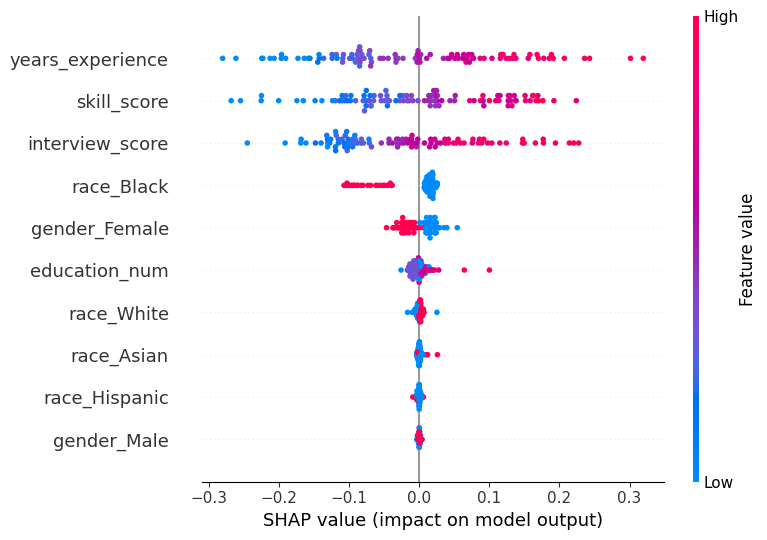

In [35]:
import shap
import numpy as np

# wrapper so model outputs a 1D vector instead of 2D proba
def predict_fn(X):
    return model.predict_proba(X)[:, 1]

# small background for SHAP (KernelExplainer is slow)
X_background = X_train.sample(100, random_state=0).values

# sample from test data
X_sample = X_test.sample(100, random_state=42).values

explainer = shap.KernelExplainer(predict_fn, X_background)

# nsamples controls runtime (larger = more accurate)
shap_values = explainer.shap_values(X_sample, nsamples=200)

# shap_values is shape (n_rows, n_features)
shap.summary_plot(shap_values, X_test.sample(100, random_state=42))


## **Local explanation example**

Local explanations help answer the question:

> **Why did the model predict *this* specific applicant should or should not be hired?**

By selecting a single instance, we can visualize:

- The model’s baseline prediction  
- Feature contributions pushing the prediction up or down  
- Whether demographic attributes influenced this particular decision  

Local SHAP plots (force plots, waterfall plots) are powerful tools for model debugging and communicating results to stakeholders such as HR teams, compliance officers, or auditors.


Index: 2390


,years_experience,education_num,skill_score,interview_score,gender_Female,gender_Male,race_Asian,race_Black,race_Hispanic,race_White
2390,2.0,1,100.0,77.2,False,True,False,True,False,False


  0%|          | 0/1 [00:00<?, ?it/s]

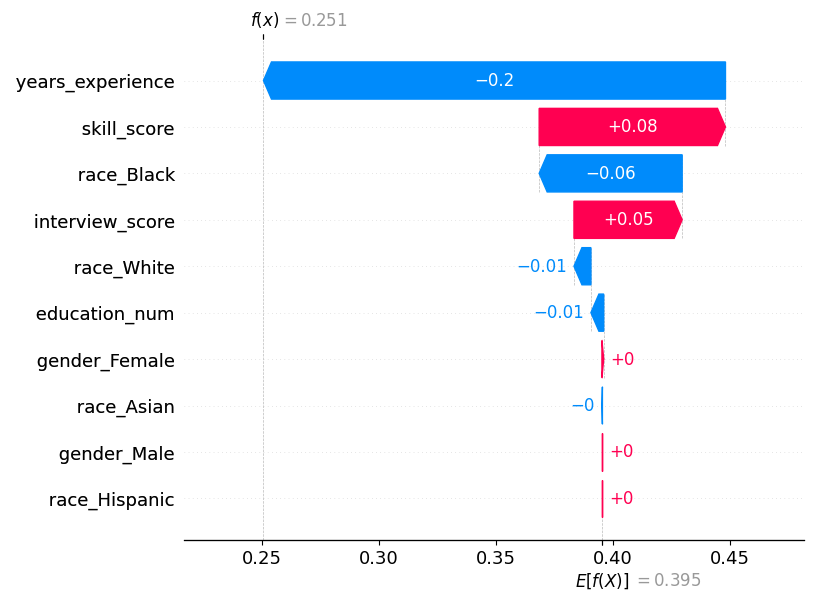

In [36]:
# Local explanation
idx = X_test.sample(1, random_state=7).index[0]
print('Index:', idx)
display(X_test.loc[idx:idx])
# For notebook environments, use waterfall_plot for static display
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, explainer.shap_values(X_test.loc[[idx]]).flatten(), X_test.loc[[idx]].iloc[0])

## **Fairness metrics**

After training the model, we evaluate its behavior across demographic groups using standard fairness metrics:

- **Demographic Parity Difference (DPD):**  
  Difference in positive prediction rates between protected and unprotected groups.

- **Disparate Impact Ratio (DIR):**  
  Ratio of positive prediction rates (values < 0.8 typically raise concerns).

- **Equal Opportunity Difference (EOD):**  
  Difference in true positive rates between groups.

These metrics help reveal whether the model systematically disadvantages certain groups, even if overall accuracy is high. Fairness analysis is essential for building ethical and legally compliant ML systems.


In [37]:
def demographic_parity_difference(y_true, y_pred, group, privileged_value):
    dfm = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred, 'group': group})
    p_priv = dfm[dfm['group'] == privileged_value]['y_pred'].mean()
    p_unpriv = dfm[dfm['group'] != privileged_value]['y_pred'].mean()
    return p_priv - p_unpriv

def disparate_impact_ratio(y_true, y_pred, group, privileged_value):
    dfm = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred, 'group': group})
    p_priv = dfm[dfm['group'] == privileged_value]['y_pred'].mean()
    p_unpriv = dfm[dfm['group'] != privileged_value]['y_pred'].mean()
    if p_priv == 0:
        return float('nan')
    return p_unpriv / p_priv

def true_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    if (tp + fn) == 0:
        return 0.0
    return tp / (tp + fn)

def equal_opportunity_difference(y_true, y_pred, group, privileged_value):
    dfm = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred, 'group': group})
    tpr_priv = true_positive_rate(dfm[dfm['group'] == privileged_value]['y_true'], dfm[dfm['group'] == privileged_value]['y_pred'])
    tpr_unpriv = true_positive_rate(dfm[dfm['group'] != privileged_value]['y_true'], dfm[dfm['group'] != privileged_value]['y_pred'])
    return tpr_priv - tpr_unpriv

# Compute metrics
priv_gender = 'Male'
priv_race = 'White'
dpd_gender = demographic_parity_difference(y_test.values, y_pred, g_test, priv_gender)
dir_gender = disparate_impact_ratio(y_test.values, y_pred, g_test, priv_gender)
eod_gender = equal_opportunity_difference(y_test.values, y_pred, g_test, priv_gender)

dpd_race = demographic_parity_difference(y_test.values, y_pred, r_test, priv_race)
dir_race = disparate_impact_ratio(y_test.values, y_pred, r_test, priv_race)
eod_race = equal_opportunity_difference(y_test.values, y_pred, r_test, priv_race)

print('Gender - Demographic Parity Diff:', dpd_gender)
print('Gender - Disparate Impact Ratio (unpriv/priv):', dir_gender)
print('Gender - Equal Opportunity Difference (priv - unpriv):', eod_gender)
print('Race - Demographic Parity Diff:', dpd_race)
print('Race - Disparate Impact Ratio (unpriv/priv):', dir_race)
print('Race - Equal Opportunity Difference (priv - unpriv):', eod_race)

Gender - Demographic Parity Diff: 0.14972424835438536
Gender - Disparate Impact Ratio (unpriv/priv): 0.5926230698484921
Gender - Equal Opportunity Difference (priv - unpriv): 0.1326557138400749
Race - Demographic Parity Diff: 0.07050610313120326
Race - Disparate Impact Ratio (unpriv/priv): 0.7829220695709549
Race - Equal Opportunity Difference (priv - unpriv): 0.08832815734989646


## **Compare SHAP attributions by group**

SHAP values can be grouped by demographic attributes to analyze whether the model treats groups differently.

In this section we:

- Compute mean absolute SHAP values separately for Male vs Female  
- Compare the top contributing features for each group  
- Identify whether certain groups rely more heavily on certain predictors  
- Detect whether demographic variables drive unequal prediction patterns  

This intersection of *explainability* and *fairness* provides a deeper understanding of model behavior and highlights subtle biases that aggregate metrics may miss.


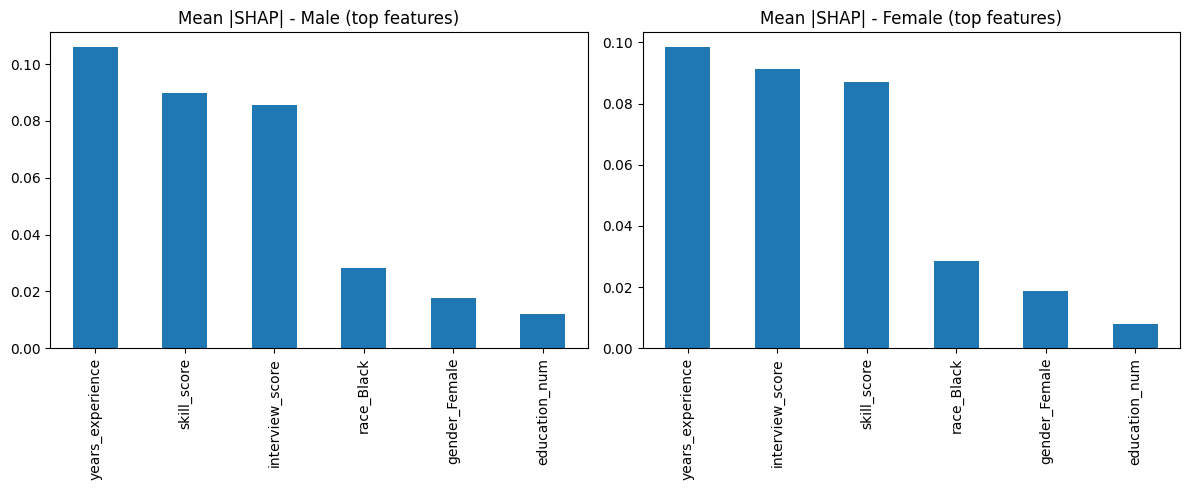

In [38]:
# --- Safe group-wise mean |SHAP| computation and plotting ---

# shap_vals_full should be a 2D numeric array (n_samples x n_features).
# shap_df created earlier:
# shap_df = pd.DataFrame(shap_vals_full, columns=X_test_reset.columns)
# shap_df['gender'] = g_test
# shap_df['race'] = r_test

# Select only numeric feature columns (exclude gender/race which are strings)
numeric_cols = shap_df.select_dtypes(include=['number']).columns.tolist()

# Compute mean absolute SHAP per numeric feature for each gender
male_mask = shap_df['gender'] == 'Male'
female_mask = shap_df['gender'] == 'Female'

mean_abs_male = shap_df.loc[male_mask, numeric_cols].abs().mean().sort_values(ascending=False)[:6]
mean_abs_female = shap_df.loc[female_mask, numeric_cols].abs().mean().sort_values(ascending=False)[:6]

# Plot side-by-side
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
mean_abs_male.plot.bar(ax=ax[0], title='Mean |SHAP| - Male (top features)')
mean_abs_female.plot.bar(ax=ax[1], title='Mean |SHAP| - Female (top features)')
plt.tight_layout()
plt.show()


## **Mitigation 1: Reweighing (pre-processing)**

Reweighing adjusts the importance (weights) of training samples so that disadvantaged groups receive more influence during model training.

In this notebook, we:

- Compute group-specific selection rates  
- Assign larger weights to underrepresented or penalized groups  
- Retrain the model with these weights  

Expected outcomes:

- Reduced disparity in positive prediction rates  
- More balanced model behavior across demographic groups  
- Improved fairness without altering the underlying feature distributions  

Reweighing is a simple yet effective pre-processing mitigation technique.


In [39]:
# Simple reweighing by gender
df_train = X_train.copy()
df_train['hire'] = y_train.values
df_train['gender'] = g_train
train_group_rates = df_train.groupby('gender')['hire'].mean()
overall = df_train['hire'].mean()
train_weights = df_train['gender'].map(lambda g: overall / train_group_rates[g])

model_w = xgb.XGBClassifier(n_estimators=200, max_depth=4, learning_rate=0.05, use_label_encoder=False, eval_metric='logloss', random_state=42)
model_w.fit(X_train, y_train, sample_weight=train_weights)
y_pred_w = model_w.predict(X_test)
print('Accuracy weighted:', accuracy_score(y_test, y_pred_w))
print('DPD gender after reweighing:', demographic_parity_difference(y_test.values, y_pred_w, g_test, priv_gender))

C:\Users\sruja\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:199: UserWarning: [22:58:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy weighted: 0.692
DPD gender after reweighing: 0.13623910336239103


## **Mitigation 2: Thresholding (post-processing)**

Thresholding modifies the decision threshold *after* model training to balance positive prediction rates across groups.

Key steps include:

- Computing group-specific predicted probability distributions  
- Selecting thresholds that equalize hiring rates or true positive rates  
- Evaluating the trade-offs between accuracy and fairness  

Advantages:

- No need to retrain the model  
- Works with any classifier  
- Easy to explain to stakeholders  

Thresholding demonstrates how fairness constraints can be applied operationally in real decision pipelines.


In [40]:
# Post-processing: adjust threshold for female to equalize positive rates to male
y_proba = model.predict_proba(X_test)[:,1]
df_probs = pd.DataFrame({'proba': y_proba, 'gender': g_test, 'y_true': y_test})
male_rate = (df_probs[df_probs['gender']=='Male']['proba'] > 0.5).mean()

female_probs = df_probs[df_probs['gender']=='Female']['proba'].values
thresholds = np.linspace(0,1,501)
best_t = 0.5
best_diff = 1.0
for t in thresholds:
    rate = (female_probs > t).mean()
    diff = abs(rate - male_rate)
    if diff < best_diff:
        best_diff = diff
        best_t = t
print('Chosen threshold for Female:', best_t)

# adjusted predictions
adj_pred = []
for prob, g in zip(df_probs['proba'], df_probs['gender']):
    t = best_t if g=='Female' else 0.5
    adj_pred.append(int(prob > t))
adj_pred = np.array(adj_pred)
print('DPD gender after thresholding:', demographic_parity_difference(y_test.values, adj_pred, g_test, priv_gender))
print('Accuracy after thresholding:', accuracy_score(y_test, adj_pred))

Chosen threshold for Female: 0.406
DPD gender after thresholding: -0.0009606831524639481
Accuracy after thresholding: 0.676


## Discussion & Takeaways

- SHAP helps reveal which features drive model decisions.
- Fairness metrics show group-level disparities consistent with the synthetic penalty.
- Mitigation strategies reduced disparity; discuss tradeoffs: accuracy vs fairness, per-group thresholds fairness vs individual fairness, reweighing may hide structural bias in data.

---

**Next steps:** Try increasing/decreasing the bias penalties in the `generate_synthetic_hiring` function and re-run steps to observe how explanations and metrics change. Consider experimenting with logistic regression or other mitigation methods (e.g., fairlearn).

## Workflow diagram — what we'll do in this notebook

```
Synthetic data generation --> Feature engineering --> Model training (XGBoost)
            |                                      |
            v                                      v
   Inject controlled bias                      SHAP explanations
            |                                      |
            v                                      v
   Compute fairness metrics  <----------------- Mitigation strategies
                        (DPD, DIR, EOD)
```

This diagram shows the high-level data & analysis flow. We'll run experiments (two bias levels) and compare results to illustrate how attribution (SHAP) and fairness metrics change.


## Scenario B — Stronger injected bias

Now we run a second scenario where the penalties for certain protected groups are stronger (e.g., Black: -10, Female: -5). This helps students observe how SHAP and fairness metrics respond as bias severity increases.


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\sruja\AppData\Local\Temp\ipykernel_28756\3133871787.py:27: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals_b, Xb_sample_df, show=True)


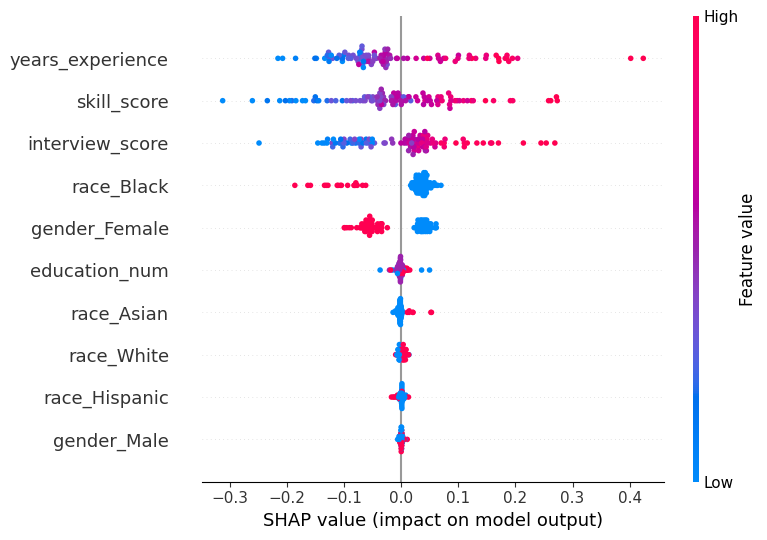

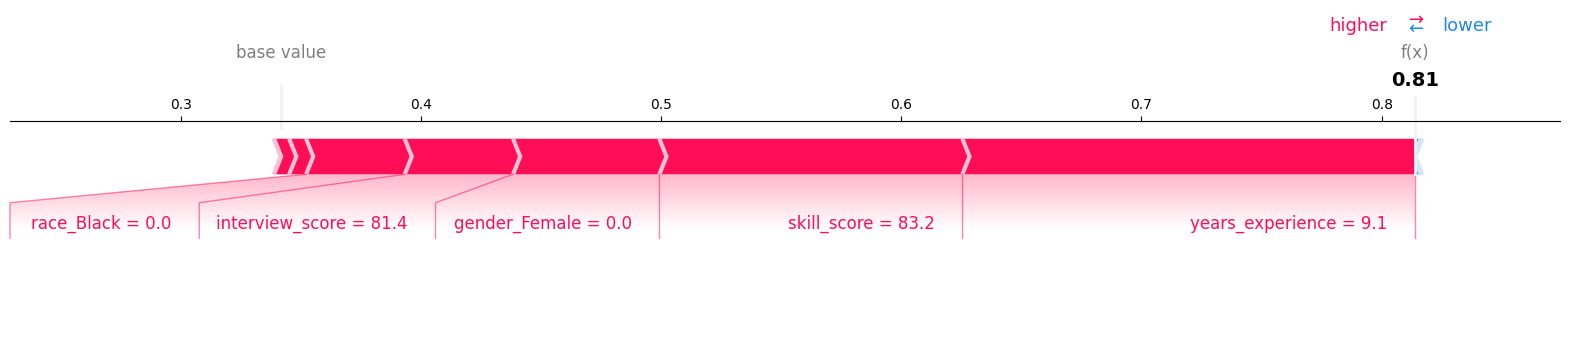

In [44]:
# --- Robust SHAP for Scenario B using KernelExplainer (replace failing TreeExplainer block) ---
import shap
import numpy as np
import pandas as pd

# wrapper so model returns 1D positive-class probability
def predict_fn_b(X):
    # X may be numpy array or DataFrame - ensure shape is correct
    return model_b.predict_proba(np.asarray(X))[:, 1]

# small background (KernelExplainer is slower; keep background small for speed)
Xb_background_df = Xb_train.sample(min(100, len(Xb_train)), random_state=1)
Xb_background = Xb_background_df.values

# sample to explain (keep small while developing)
Xb_sample_df = Xb_test.sample(min(100, len(Xb_test)), random_state=7)
Xb_sample = Xb_sample_df.values

# build KernelExplainer with the wrapper
explainer_b = shap.KernelExplainer(predict_fn_b, Xb_background)

# compute SHAP values (nsamples controls speed vs fidelity)
# 100-200 is a good balance for teaching notebooks
shap_vals_b = explainer_b.shap_values(Xb_sample, nsamples=150)

# shap_vals_b is (n_rows, n_features). Visualize using the DataFrame for labels
shap.summary_plot(shap_vals_b, Xb_sample_df, show=True)

# Optional: local explanation for the first instance in Xb_sample_df
i = 0
shap.force_plot(
    explainer_b.expected_value,
    shap_vals_b[i],
    Xb_sample_df.iloc[i],
    matplotlib=True,
    show=True
)


## Compare Scenario A (original) vs Scenario B (strong bias)

This cell computes and prints a short comparison of key fairness metrics to make the changes explicit for learners.


In [42]:
# Compare key metrics between scenario A (dpd_gender, dir_gender, etc.) and scenario B
try:
    print('--- Scenario A (original) ---')
    print('Gender DPD (A):', dpd_gender)
    print('Race DPD (A):', dpd_race)
    print('\n--- Scenario B (strong bias) ---')
    print('Gender DPD (B):', dpd_gender_b)
    print('Race DPD (B):', dpd_race_b)
except NameError:
    print('Run the earlier cells for Scenario A and Scenario B before comparing.')

# Suggest visual comparison (bar chart)
try:
    vals = {
        'Scenario A - Gender DPD': float(dpd_gender),
        'Scenario B - Gender DPD': float(dpd_gender_b),
        'Scenario A - Race DPD': float(dpd_race),
        'Scenario B - Race DPD': float(dpd_race_b)
    }
    pd.Series(vals).plot(kind='bar', figsize=(8,4), title='DPD comparison (A vs B)')
    plt.ylabel('Demographic Parity Difference (priv - unpriv)')
    plt.show()
except Exception as e:
    pass


--- Scenario A (original) ---
Gender DPD (A): 0.14972424835438536
Race DPD (A): 0.07050610313120326

--- Scenario B (strong bias) ---
Run the earlier cells for Scenario A and Scenario B before comparing.


## Exercises — Try these (in-notebook)

1. **Increase bias magnitude:** Modify the penalty values in `generate_synthetic_hiring` (try Black: -15, Female: -8), regenerate data, retrain, and report how DPD and DIR changed. Explain why.

2. **Feature ablation:** Remove `education_num` and re-train the model on Scenario A. Compare SHAP summary plots and fairness metrics. Did removing the feature reduce group disparity? Why or why not?

3. **Model comparison:** Replace XGBoost with `LogisticRegression` (from `sklearn.linear_model`) and compare coefficients with SHAP attributions. Which model shows more interpretable behavior? How do fairness metrics differ?

*(Instructor note: students should submit a short answers cell with screenshots or printed metrics.)*


## Debugging tips & common pitfalls

- **SHAP is slow / large memory use:** Use a sample (`X_test.sample(500)`) for global plots and `explainer.shap_values` on smaller subsets.
- **NaN in disparate impact:** If privileged group has zero positive predictions, DIR is undefined — interpret carefully and consider smoothing.
- **Stratify errors when splitting:** If the class distribution is too imbalanced, stratify may fail. Use `stratify=None` or adjust dataset size.
- **Inconsistent SHAP results between runs:** Set seeds for dataset generation and model training to obtain reproducible SHAP values.
- **Mitigation reduces accuracy:** This is expected; document the tradeoff and show per-group performance.


## Reflection — what did we learn?

1. Attribution (SHAP) and fairness metrics are complementary: SHAP explains *why* a model predicts as it does; fairness metrics measure *who* is impacted.
2. Increasing synthetic bias made disparities larger and SHAP helped identify which features the model relied on.
3. Mitigation strategies (reweighing, thresholding) improved group-level fairness but at a cost to accuracy or individual-level fairness.

**Instructor tip:** Ask students to reflect on the ethical implications of deploying such models in real hiring pipelines.


## Optional interactive widget: explore thresholding per group

This small widget lets you slide a threshold for the Female group to see how positive rate and DPD change. (Requires `ipywidgets` in your environment.)


In [43]:
try:
    import ipywidgets as widgets
    from IPython.display import display
    
    y_proba = model.predict_proba(X_test)[:,1]
    df_probs = pd.DataFrame({'proba': y_proba, 'gender': g_test, 'y_true': y_test})
    male_rate = (df_probs[df_probs['gender']=='Male']['proba'] > 0.5).mean()

    def explore(threshold=0.5):
        female_rate = (df_probs[df_probs['gender']=='Female']['proba'] > threshold).mean()
        dpd = demographic_parity_difference(y_test.values, (df_probs['proba']>threshold).astype(int).values, g_test, 'Male')
        print(f'Female threshold: {threshold:.2f} | Female positive-rate: {female_rate:.3f} | Male positive-rate: {male_rate:.3f} | approx DPD (priv-unpriv): {dpd:.3f}')

    slider = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01, description='Female Thr:')
    widgets.interact(explore, threshold=slider)
except Exception as e:
    print('ipywidgets not available or an error occurred:', e)


interactive(children=(FloatSlider(value=0.5, description='Female Thr:', max=1.0, step=0.01), Output()), _dom_c…